[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [40]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [41]:
import os
from dotenv import load_dotenv

load_dotenv("../../.env")

True

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [42]:
load_dotenv()
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "default"

In [43]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Ojasw"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Ojasw

Yes, I know about whales. But what others should I learn about?


## Messages as state

First, let's define some messages.

In [44]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching Greek mythology?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about Zeus. But what other gods should I learn about?", name="Ojasw"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching Greek mythology?
================================ Human Message =================================
Name: Ojasw

Yes, I know about Zeus. But what other gods should I learn about?


Recall we can pass them to a chat model.

In [45]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-haiku-4-5-20251001")
llm.invoke(messages)

AIMessage(content='# Greek Gods Worth Exploring\n\nHere are some key Olympian deities and others you might find interesting:\n\n## The Twelve Olympians\n- **Hera** - Queen of the gods, goddess of marriage and family\n- **Poseidon** - God of the sea, earthquakes, and horses\n- **Demeter** - Goddess of agriculture and the harvest\n- **Athena** - Goddess of wisdom and warfare strategy\n- **Apollo** - God of music, poetry, healing, and the sun\n- **Artemis** - Goddess of the hunt and the moon\n- **Ares** - God of war (violent aspects)\n- **Aphrodite** - Goddess of love and beauty\n- **Hephaestus** - God of metalworking and fire\n- **Hermes** - Messenger god and guide of souls\n- **Dionysus** - God of wine, theater, and revelry\n\n## Other Important Deities\n- **Hades** - God of the underworld (sometimes counted as an Olympian)\n- **Hecate** - Goddess of magic and crossroads\n- **Nike** - Goddess of victory\n\n**Which of these interests you most?** The stories often overlap, so knowing the 

We can run our chat model in a simple graph with `MessagesState`.

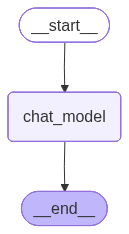

In [46]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching Greek mythology?
================================ Human Message =================================
Name: Ojasw

Yes, I know about Zeus. But what other gods should I learn about?
================================== Ai Message ==================================

# Greek Gods Worth Exploring

Here are some key figures beyond Zeus:

**The Olympians:**
- **Hades** - God of the underworld; often misunderstood as purely evil, but complex and important
- **Poseidon** - God of the sea, earthquakes, and horses; Zeus's brother
- **Athena** - Goddess of wisdom and warfare strategy
- **Apollo** - God of music, poetry, prophecy, and the sun
- **Aphrodite** - Goddess of love and beauty
- **Ares** - God of war (contrast with Athena's strategic warfare)

**Others of Interest:**
- **Hermes** - Messenger god; trickster figure with interesting stories
- **Hephaestus** - God of blacksm

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

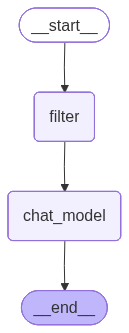

In [48]:
from langchain_core.messages import RemoveMessage

def filter_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Ojasw", id="2"))
messages.append(AIMessage("So you said you were researching Greek mythology?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about Zeus. But what other gods should I learn about?", name="Ojasw", id="4"))

output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching Greek mythology?
================================ Human Message =================================
Name: Ojasw

Yes, I know about Zeus. But what other gods should I learn about?
================================== Ai Message ==================================

# Other Important Greek Gods

Here are some key gods worth learning about:

**The Olympians:**
- **Poseidon** - God of the sea, earthquakes, and storms
- **Hades** - God of the underworld and the dead
- **Athena** - Goddess of wisdom, warfare strategy, and crafts
- **Apollo** - God of music, poetry, healing, and the sun
- **Artemis** - Goddess of the hunt and the moon
- **Ares** - God of war and violence (contrast to Athena's strategic warfare)
- **Aphrodite** - Goddess of love and beauty
- **Hermes** - Messenger god; also patron of travelers and thieves
- **Hephaestus** - God of blacksmiths and metalworking


## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

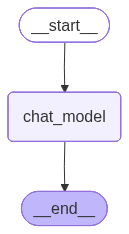

In [50]:
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [51]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Athena!", name="Ojasw"))

In [52]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Ojasw

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching Greek mythology?
================================ Human Message =================================
Name: Ojasw

Yes, I know about Zeus. But what other gods should I learn about?
================================== Ai Message ==================================

# Other Important Greek Gods

Here are some key gods worth learning about:

**The Olympians:**
- **Poseidon** - God of the sea, earthquakes, and storms
- **Hades** - God of the underworld and the dead
- **Athena** - Goddess of wisdom, warfare strategy, and crafts
- **Apollo** - God of music, poetry, healing, and the sun
- **Artemis** - Goddess of the hunt and the moon
- **Ares** - God of war and violence (contrast to A

In [53]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Ojasw

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching Greek mythology?
================================ Human Message =================================
Name: Ojasw

Yes, I know about Zeus. But what other gods should I learn about?
================================== Ai Message ==================================

# Other Important Greek Gods

Here are some key gods worth learning about:

**The Olympians:**
- **Poseidon** - God of the sea, earthquakes, and storms
- **Hades** - God of the underworld and the dead
- **Athena** - Goddess of wisdom, warfare strategy, and crafts
- **Apollo** - God of music, poetry, healing, and the sun
- **Artemis** - Goddess of the hunt and the moon
- **Ares** - God of war and violence (contrast to A

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

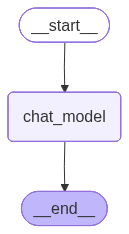

In [54]:
from langchain_core.messages import trim_messages

def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatAnthropic(model="claude-haiku-4-5-20251001"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Poseidon lived!", name="Ojasw"))

In [56]:
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatAnthropic(model="claude-haiku-4-5-20251001"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Poseidon lived!', additional_kwargs={}, response_metadata={}, name='Ojasw')]

In [57]:
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/53c5cb38-5f36-4f60-b20e-5ba5d951f54d/r